In this project we will:

1 - Simulate Time Series data using AutoRegressive (AR) modeling

2 - Learn about Fourier Transform and its application

3 - Learn about the difference between "static" FFT amd Welch's Method

To get from time domain to frequency domain, the best way is to use Fourier Transform.

We take a sine wave and overlay it on the signal by using dot product.

If time series is shifted, we solve it by computing the dot product with a complex sinewave, with real and imaginary component. This handles all the cases where there is phase shift. 

## Simulate an AR Process

Auto-Regression means to sort of regress a variable on itself. The equation illustrates the way it works.  $x_t = \alpha x_{t-1} + \epsilon_t$. This equation can be understood as: the signal at time t equals some past version of itself multiplied by a weight factor alpha plus an error term (noise, novelty factor, error...). This AR1 process can be generalized to an AR-k as: $x_t = \sum_{i = 1}^k (\alpha_ix_{t-i}) + \epsilon_t$ where we go back k-time points. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

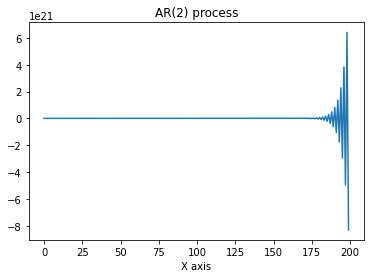

In [2]:
# Without using numpy
N = 200
alpha = np.array([-0.6, 0.9])
k = len(alpha)
x = np.zeros(N)
for i in range(2,N):
    x[i] = alpha[0]*x[i-1] + alpha[1]*x[i-2] + np.random.randn()
x += np.sin(np.linspace(0, 10*np.pi, N))
plt.plot(x)
plt.xlabel("X axis")
plt.title("AR(%s) process"%k)
plt.show()

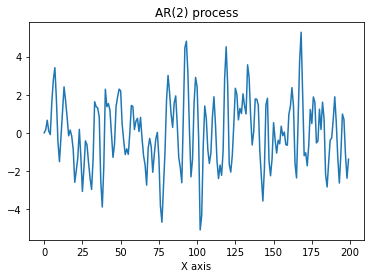

In [3]:
# Using Numpy
N = 200
alpha = np.array([-0.6, 0.9]) # Changes frequency dynamics
k = len(alpha)
x = np.zeros(N)
for i in range(k,N):
    x[i] = sum(alpha*x[i-k:i]) + np.random.randn()
# Add a sine wave 
x += np.sin(np.linspace(0, 10*np.pi, N)) # Multiply to change amplitude
plt.plot(x)
plt.xlabel("X axis")
plt.title("AR(%s) process"%k)
plt.show()

## Fourier Transform (FT) Algorithm

Complex Sine wave: $s = \exp^{-i2\pi ft}$ f is scalar (looping index) and t is a vector of time points (0->N)/N

Dot Product: $c_f = \sum{k=1}^n s_kx_k$ Also called the Fourier Coefficient

In [4]:
# Loop over N-points/frequencies (looping index f): Number of time points
# Create complex sine wave with length of signal, and frequency of the looping index
# Compute the dot product betwen cpmplex sine wave and the signal
# Amplitude is the magnitude of Fourier Coefficients
# Phase is the angle of Fourier Coefficients

# Initialize Fourier Coefficients
fc = np.zeros(N, dtype = complex)

# Define time vector
t = np.arange(N)/N

# Manual Fourier Transform
for f in range(N):
    # create complex sine wave
    csw = np.exp(-1j*2*np.pi*f*t)
    
    # dot product with signal
    fc[f] = np.dot(csw,x)

In [5]:
# Built-in FFT function
fc2 = np.fft.fft(x)

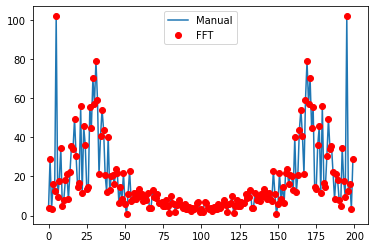

In [6]:
# Compare our function with fft
plt.plot(np.abs(fc), label = "Manual")
plt.plot(np.abs(fc2), "ro", label = "FFT")
plt.legend()
plt.show()

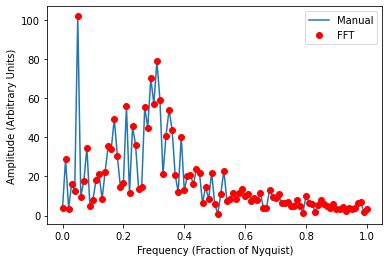

In [7]:
# The above plot shows a mirror image of positive and negaive frequencies
# We can isolate positive frequencies only

hz = np.linspace(0,1,int(N/2+1))

plt.plot(hz, np.abs(fc[:len(hz)]), label = "Manual")
plt.plot(hz, np.abs(fc2[:len(hz)]), "ro", label = "FFT")
plt.legend()
plt.xlabel("Frequency (Fraction of Nyquist)")
plt.ylabel("Amplitude (Arbitrary Units)")
plt.show()

## Zero-Padding the FFT

Zero Padding, as the name suggests means to pad the time series with zeros. The number of zeros added can be abitrary. The reason this is done before doing FT is to smooth out the signal representation, so the signal is similar to the original but smoother.

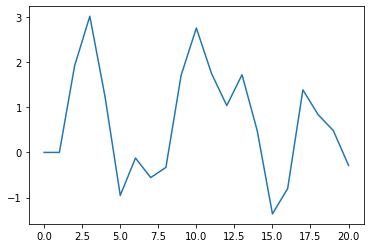

In [8]:
# Use just 21 points
alpha = np.array([-0.6, 0.9])
k = len(alpha)
N = 21
x = np.zeros(N)

for i in range(k,N):
    x[i] = sum(alpha*x[i-k:i]) + np.random.randn()
    
plt.plot(x)

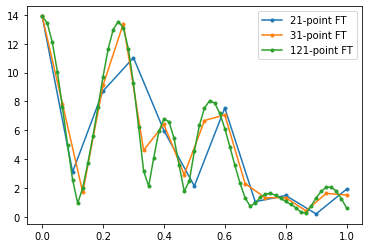

In [9]:
for i in range(3):
    # specify the number of FFT points (including zero points)
    nfft = N + 10**i*int(i != 0) # [1,10,100]
    # Compute the FFT
    xX = np.fft.fft(x,n = nfft) # zero-pad by 10 (21+10)
    # compute hz vector
    hz = np.linspace(0,1,int(nfft/2+1))
    # Plot the amplitude spectrum
    plt.plot(hz, np.abs(xX[:len(hz)]), ".-", label = "%s-point FT"%nfft)
plt.legend()
plt.show()

## Welch's Method

**Welch's Idea**: Instead of taking the whole FT of the spectra, take a snippet of the time series and FT it. Then take another segment overlapping with the first and FT again. Do this iteratively throughout the entire length of the signal, creating a number of spectra and then average them to get a final spectra.

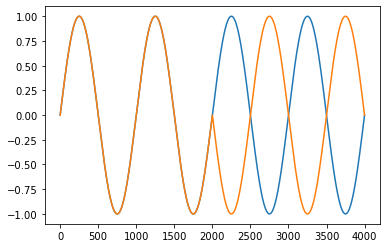

In [10]:
# Lets create two signals, first overlapping and then one of them flips
N = 2000
t = np.linspace(0, 4*np.pi, N)
signal1 = np.concatenate((np.sin(t), np.sin(t)))
signal2 = np.concatenate((np.sin(t),-np.sin(t)))

plt.plot(signal1)
plt.plot(signal2)
plt.show()

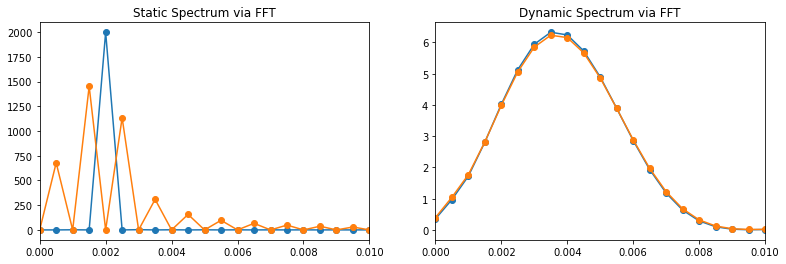

In [11]:
# Static Fourier Transform
staticX1 = np.fft.fft(signal1)
staticX2 = np.fft.fft(signal2)
staticHz = np.linspace(0, 1, int(len(signal1)/2+1))

# Welch's Method
dynamicHz, dynamicX1 = welch(signal1,nfft = N)
dynamicHz, dynamicX2 = welch(signal2,nfft = N)

fig,ax = plt.subplots(1,2, figsize = (13,4))

ax[0].plot(staticHz, np.abs(staticX1[:len(staticHz)]), 
           "-o", label = "Signal1")
ax[0].plot(staticHz, np.abs(staticX2[:len(staticHz)]), 
           "-o", label = "Signal2")
ax[0].set_xlim([0,.01])
ax[0].set_title("Static Spectrum via FFT")
ax[1].plot(dynamicHz, np.abs(dynamicX1[:len(dynamicHz)]), 
           "-o", label = "Signal1")
ax[1].plot(dynamicHz, np.abs(dynamicX2[:len(dynamicHz)]), 
           "-o", label = "Signal2")
ax[1].set_xlim([0,.01])
ax[1].set_title("Dynamic Spectrum via FFT")

plt.show()

## Bonus: Spectrogram

We will perform a time-frequency Analysis of the sine wave we crated in the previous section.

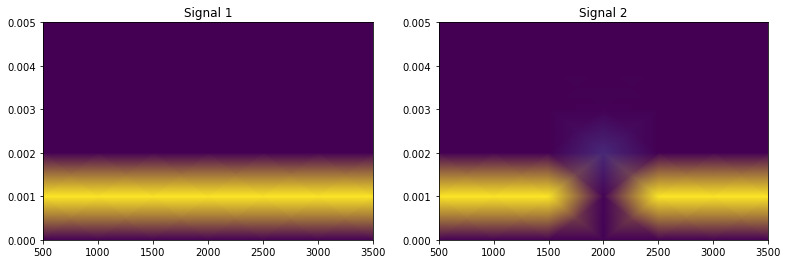

In [12]:
f1, t1, Sxx1 = spectrogram(signal1, nperseg = 1000, noverlap = 500)
f2, t2, Sxx2 = spectrogram(signal2, nperseg = 1000, noverlap = 500)
fig,ax = plt.subplots(1,2, figsize = (13,4))
ax[0].pcolormesh(t1, f1, Sxx1, shading = "gouraud")
ax[0].set_ylim([0, 0.005])
ax[0].set_title("Signal 1")
ax[1].pcolormesh(t2, f2, Sxx2, shading = "gouraud")
ax[1].set_ylim([0, 0.005])
ax[1].set_title("Signal 2")
plt.show()